In [175]:
import otter
grader = otter.Notebook()

In [176]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
import pandas as pd

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# 1. The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [177]:
movies = pd.read_csv('movies.csv')
movies[movies["Title"] == "wild wild west"].iloc[:,[0, 1, 2, 3, 4, 14, 49, 1042, 4004]]

,Title,Year,Rating,Genre,# Words,breez,england,it,bravo
241,wild wild west,1999,4.3,comedy,3446,0.0,0.0,0.021263,0.0


The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. Here we'll turn the movie's Title column into its index as well. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [178]:
movies = movies.set_index('Title', drop = False)
movies["Title"] = movies.index
movies

,Title,Year,Rating,Genre,# Words,she,decid,talk,wit,razor,...,eight,morgu,comin,style,cadet,uh,uhuh,earn,tini,volunt
Title,,,,,,,,,,,,,,,,,,,,,
10 things i hate about you,10 things i hate about you,1999,6.9,comedy,5341,0.006167,0.000597,0.001591,0.000199,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000597,0.0,0.000000,0.000000,0.0
sister act,sister act,1992,5.9,comedy,7401,0.009293,0.000000,0.001971,0.000563,0.0,...,0.000000,0.000000,0.000000,0.000141,0.0,0.000000,0.0,0.000000,0.000000,0.0
the boondock saints,the boondock saints,1999,7.8,thriller,5705,0.002246,0.000561,0.002433,0.000374,0.0,...,0.000749,0.000000,0.000374,0.000000,0.0,0.001310,0.0,0.000187,0.000000,0.0
mystery men,mystery men,1999,5.9,comedy,3144,0.003308,0.000000,0.001985,0.000000,0.0,...,0.000331,0.000000,0.000000,0.000662,0.0,0.000662,0.0,0.000000,0.000000,0.0
blade,blade,1998,7.0,thriller,2886,0.001098,0.000000,0.001098,0.000000,0.0,...,0.000000,0.000366,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
the thin man,the thin man,1934,8.1,comedy,7611,0.006339,0.000270,0.001484,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
wonder boys,wonder boys,2000,7.5,comedy,7895,0.006357,0.000265,0.000927,0.000000,0.0,...,0.000132,0.000000,0.000000,0.000132,0.0,0.000662,0.0,0.000000,0.000132,0.0
the war of the worlds,the war of the worlds,1953,7.1,thriller,2141,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


The fastest way to find the frequency of "none" in the movie *The Terminator* is to access the `'none'` item from its row. You can use `.iloc` to subset by row index. You can also access the movie's row by subsetting its Title column (`== "the terminator"`), though it is considerably slower than by using the row index. This is something to consider since the dataset we're working with is relatively large (12.2MB).

In [179]:
movies.loc['the terminator']['none'] 

0.0009633911368015

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

## 1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [180]:
# Just run this cell.
vocab_mapping = pd.read_csv('stem.csv')
stemmed = np.take(movies.columns, np.arange(3, len(movies.columns)))

vocab_table = pd.DataFrame({'Stem': stemmed})
vocab_table = pd.merge(vocab_table, vocab_mapping, on = "Stem", how = "left")
vocab_table[1101:1111]

,Stem,Word
1101,year.1,NaN
1102,shovel,shoveling
1103,shovel,shovels
1104,shovel,shovelling
1105,shovel,shoveler
1106,shovel,shoveled
1107,shovel,shovel
1108,sequenc,sequencing
1109,sequenc,sequencer
1110,sequenc,sequences


#### Question 1.1.1
Assign `stemmed_message` to the stemmed version of the word "vegetables".

<!--
BEGIN QUESTION
name: q1_1_1
-->

In [181]:
stemmed_message = vocab_table[vocab_table["Word"] == "vegetables"].iloc[0, 0]
stemmed_message

'veget'

In [182]:
grader.check("q1_1_1")

q1_1_1 results: All test cases passed!

#### Question 1.1.2
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem.

<!--
BEGIN QUESTION
name: q1_1_2
-->

In [183]:
most_stem = vocab_table["Stem"].mode().loc[0]
most_stem 

'gener'

In [184]:
grader.check("q1_1_2")

q1_1_2 results: All test cases passed!

#### Question 1.1.3
What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "albatross" or "batman", you should pick "batman").

Note that the method to find the length of a string is `.str.len()`.

<!--
BEGIN QUESTION
name: q1_1_3
-->

In [185]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?

vocab_table["addition"] = vocab_table["Stem"].str.len() + vocab_table["Word"].str.len()
vocab_table["subtraction"] = abs(vocab_table["Stem"].str.len() - vocab_table["Word"].str.len())
vocab_table["difference"] = vocab_table["addition"] - vocab_table["subtraction"]  
with_same = vocab_table.sort_values(['difference'], ascending = [False])
longest_uncut_almost = with_same['subtraction'] == 0
longest_uncut_almosty = with_same[longest_uncut_almost]
longest_uncut = longest_uncut_almosty.iloc[0,1]
longest_uncut 

'misunderstand'

In [186]:
grader.check("q1_1_3")

q1_1_3 results: All test cases passed!

## 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we'll look at the relationship between words in proportions. 

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of space proportions vs outer proportions and to create the `outer_space` table.

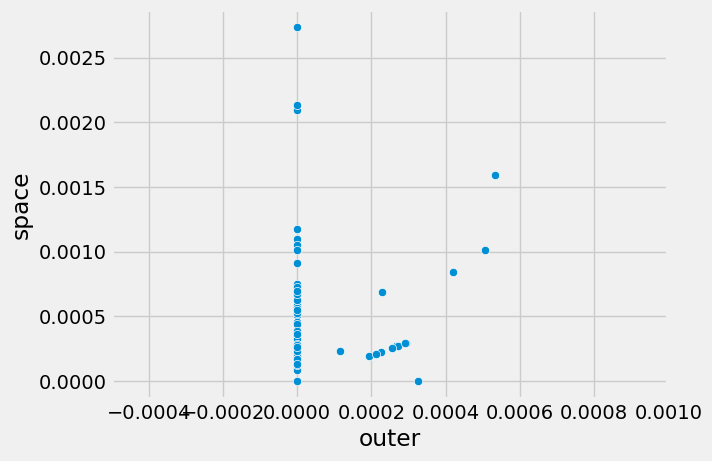

In [187]:
# Just run this cell!
outer_space = movies[["outer", "space"]]
sns.scatterplot(data = outer_space, x = "outer", y = "space")
plt.xlim(-.0005, .001);

#### Question 1.2.1
Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`.

<!--
BEGIN QUESTION
name: q1_2_1
-->

In [188]:
# Our solution took multiple lines
# these two arrays should make your code cleaner!

def standard_units(arr):
    return (arr - np.mean(arr))/np.std(arr)  

outer = movies["outer"]
space = movies["space"]

outer_su = standard_units(outer)
space_su = standard_units(space)

outer_space_r = np.average(outer_su * space_su)
outer_space_r

0.2829527833012741

In [189]:
grader.check("q1_2_1")

q1_2_1 results: All test cases passed!

#### Question 1.2.2
Choose two *different* words in the dataset with a correlation higher than 0.2 or smaller than -0.2 that are not *outer* and *space* and plot a scatter plot with a line of best fit for them. The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`.

*Hint: It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*.

*Hint 2: Try to think of common phrases or idioms*.

<!--
BEGIN QUESTION
name: q1_2_2
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

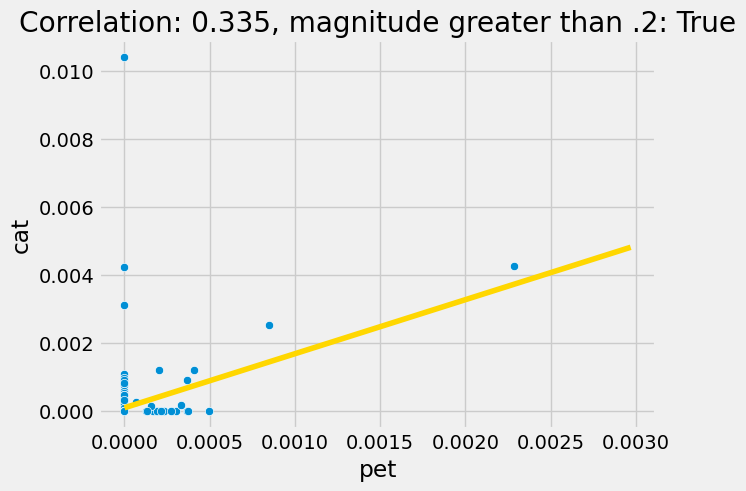

In [190]:
word_x = "pet"
word_y = "cat"

# These arrays should make your code cleaner!
arr_x = movies[word_x]
arr_y = movies[word_y]

x_su = standard_units(arr_x)
y_su = standard_units(arr_y)

r = np.average(x_su * y_su)

slope = r * (np.std(arr_y) / np.std(arr_x))
intercept = np.mean(arr_y) + (-slope) * np.mean(arr_x)

# DON'T CHANGE THESE LINES OF CODE
sns.scatterplot(x = arr_x, y = arr_y)
max_x = np.max(movies[word_x])
plt.title(f"Correlation: {np.round(r,3)}, magnitude greater than .2: {abs(r) >= 0.2}")
sns.lineplot(x = [0, max_x * 1.3], y = [intercept, intercept + slope * (max_x*1.3)], color='gold');

## 1.3. Splitting the dataset
We're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [191]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = len(movies)
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.iloc[np.arange(num_train),:]
test_movies = movies.iloc[np.arange(num_train, num_movies)]

print("Training: ",   len(train_movies), ";",
      "Test: ",       len(test_movies))

Training:  314 ; Test:  56


#### Question 1.3.1
Draw a horizontal bar chart with two bars that show the proportion of comedy movies in each dataset. Complete the function `comedy_proportion` first; it should help you create the bar chart.

<!--
BEGIN QUESTION
name: q1_3_1
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

<Axes: >

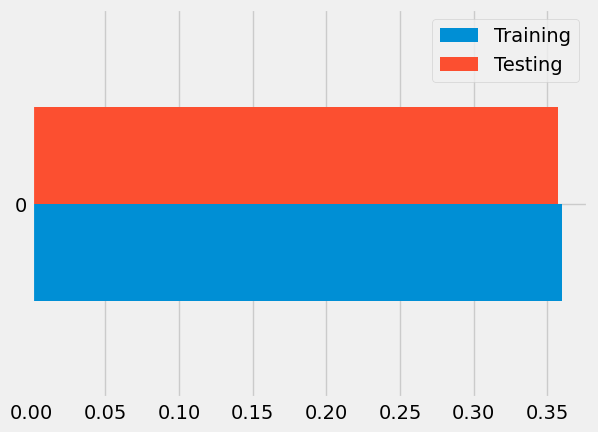

In [192]:
def comedy_proportion(table):
    boolean_comedy = table["Genre"] == "comedy"
    just_comedy = table[boolean_comedy]
    return len(just_comedy)/len(table)
    
# Create your barplot
train_proportion = comedy_proportion(train_movies)
test_proportion = comedy_proportion(test_movies)
prop_dict = {
    'Training': [train_proportion],
    'Testing': [test_proportion]
}
prop_df = pd.DataFrame(prop_dict)
prop_df.plot.barh() 

# 2. K-Nearest Neighbors - A Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features in a scatter diagram. 

**This distance is called the Euclidean distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Avengers* (in the training set), is 0 "water" and 0.00103173 "feel".

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to "Clerks." than to the *The Avengers* based on these features, which is makes sense as both movies are comedy movies, while *The Avengers* is a thriller.


In [193]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = test_movies.loc[test_movie]
    distances = pd.DataFrame({
            "x_feature": test_row[x_feature],
            "y_feature": test_row[y_feature],
            'Genre': 'unknown',
            'Title': test_movie
                }, index = [0])
    
    for movie in training_movies:
        row = train_movies.loc[movie]
        distances.loc[len(distances)] = [row[x_feature], row[y_feature], row['Genre'], movie]

    sns.set_palette("dark")
    sns.scatterplot(data = distances, x = "x_feature", y = "y_feature", hue = "Genre", s = 70)
    plt.legend(labels = distances["Title"], fontsize = "small", labelcolor = sns.color_palette()[0:3], markerscale=0)

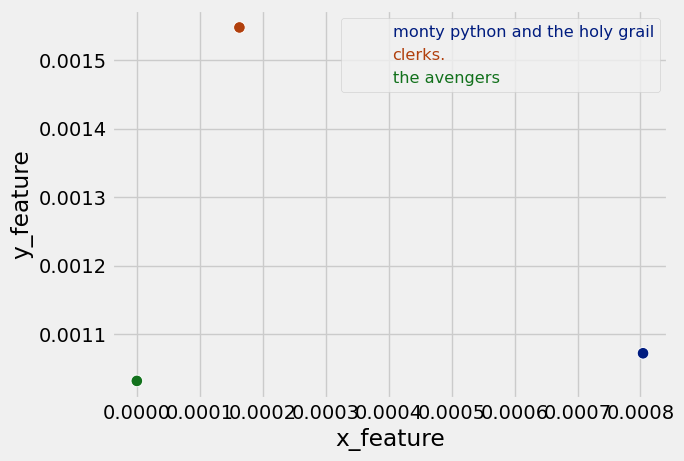

In [194]:
training = ["clerks.", "the avengers"]
plot_with_two_features("monty python and the holy grail", training, "water", "feel")

#### Question 2.1.1

Compute the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Avengers*, using the `water` and `feel` features only.  Assign it the name `one_distance`.

*Hint*: Remember that we can snag rows by the Title index using `.loc`

<!--
BEGIN QUESTION
name: q2_1_1
-->

In [195]:
python = movies.loc["monty python and the holy grail"]
avengers = movies.loc["the avengers"]
python_array = np.array([python.loc["water"], python.loc["feel"]])
avengers_array = np.array([avengers.loc["water"], avengers.loc["feel"]])                         

one_distance = np.sqrt(np.sum((python_array - avengers_array)**2))
one_distance


0.0008050869157478146

In [196]:
grader.check("q2_1_1")

q2_1_1 results: All test cases passed!

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

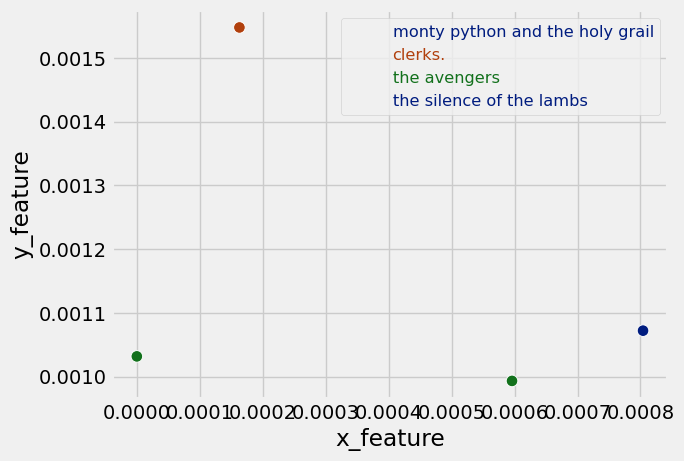

In [197]:
training = ["clerks.", "the avengers", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel");

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

<!--
BEGIN QUESTION
name: q2_1_2
-->

In [198]:
def distance_two_features(title0, title1, x_feature, y_feature):
    first_loc = movies.loc[title0]
    second_loc = movies.loc[title1]
    first_array = np.array([first_loc.loc[x_feature], first_loc.loc[y_feature]])
    second_array = np.array([second_loc.loc[x_feature], second_loc.loc[y_feature]])
    return np.sqrt(np.sum((first_array - second_array)**2))

for movie in np.array(["clerks.", "the silence of the lambs"]):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)


clerks. distance:	 0.0007983810687227716
the silence of the lambs distance:	 0.00022256314855564847


In [199]:
grader.check("q2_1_2")

q2_1_2 results: All test cases passed!

#### Question 2.1.3
Define the function `distance_from_python` so that it works as described in its documentation.

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

<!--
BEGIN QUESTION
name: q2_1_3
-->

In [200]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    distance_monty = distance_two_features("monty python and the holy grail", title, "water", "feel")
    
    return distance_monty

In [201]:
grader.check("q2_1_3")

q2_1_3 results: All test cases passed!

#### Question 2.1.4

Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  To answer this question, make a table named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table should be **sorted in ascending order by `distance from python`**.

<!--
BEGIN QUESTION
name: q2_1_4
-->

In [202]:
dist_python_array = np.empty(0)
for movie in (train_movies["Title"]):
    dist_python = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    dist_python_array = np.append(dist_python_array, dist_python)
    
dist_python_array


not_sorted = train_movies[['Title', 'Genre', 'water', 'feel']]
not_sorted['distance from python'] = dist_python_array
sorted_table = not_sorted.sort_values('distance from python', ascending = True)
close_movies = sorted_table.iloc[0:5, :]

close_movies

/tmp/ipykernel_81/3719887112.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_sorted['distance from python'] = dist_python_array


,Title,Genre,water,feel,distance from python
Title,,,,,
alien,alien,thriller,0.000709,0.001241,0.000194
tomorrow never dies,tomorrow never dies,thriller,0.000889,0.000889,0.000202
the silence of the lambs,the silence of the lambs,thriller,0.000596,0.000993,0.000223
innerspace,innerspace,comedy,0.000522,0.001044,0.000283
some like it hot,some like it hot,comedy,0.000529,0.000951,0.000301


In [203]:
grader.check("q2_1_4")

q2_1_4 results: All test cases passed!

#### Question 2.1.5
Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below.

<!--
BEGIN QUESTION
name: q2_1_5
-->

In [204]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    return table[label].mode()[0]

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

In [205]:
grader.check("q2_1_5")

q2_1_5 results: All test cases passed!

Congratulations are in order -- you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie. Let's see if we can do better!

# 3. Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### Question 3.0
Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length. 

Next, use the function you just defined to compute the distance between the first and second movie in the training set *using all of the features*.  (Remember that the first five columns of your tables are not features.)

**Note:** To convert rows to arrays, use `np.array`.

<!--
BEGIN QUESTION
name: q3_0
-->

In [206]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return np.sqrt(np.sum((features_array1 - features_array2)**2))

just_numbers = train_movies.iloc[:, 5:]
distance_first_to_second = distance(just_numbers.iloc[0], just_numbers.iloc[1])
distance_first_to_second

0.03335446890881317

In [207]:
grader.check("q3_0")

q3_0 results: All test cases passed!

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

#### Question 3.1.1
In this question, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis.


*Note: The line graphed is the line of best fit, NOT a y=x*

![alt text](word_plot.png "Title")

The following questions ask you to interpret the plot above. For each question, select one of the following choices and assign its number to the provided name.

    1. The word is common in both comedy and thriller movies 
    2. The word is uncommon in comedy movies and common in thriller movies
    3. The word is common in comedy movies and uncommon in thriller movies
    4. The word is uncommon in both comedy and thriller movies
    5. It is not possible to say from the plot 
    
What properties does a word in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

<!--
BEGIN QUESTION
name: q3_1_1
-->

In [208]:
bottom_left = 4

In [209]:
grader.check("q3_1_1")

q3_1_1 results: All test cases passed!

**Question 3.1.2**

What properties does a word in the bottom right corner have?

<!--
BEGIN QUESTION
name: q3_1_2
-->

In [210]:
bottom_right = 3

In [211]:
grader.check("q3_1_2")

q3_1_2 results: All test cases passed!

**Question 3.1.3**

What properties does a word in the top right corner have?

<!--
BEGIN QUESTION
name: q3_1_3
-->

In [212]:
top_right = 1

In [213]:
grader.check("q3_1_3")

q3_1_3 results: All test cases passed!

**Question 3.1.4**

What properties does a word in the top left corner have?

<!--
BEGIN QUESTION
name: q3_1_4
-->

In [214]:
top_left = 2

In [215]:
grader.check("q3_1_4")

q3_1_4 results: All test cases passed!

**Question 3.1.5**

If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie? Assign `movie_genre` to the number corresponding to your answer:
    1. It is a thriller movie.
    2. It is a comedy movie.
    
<!--
BEGIN QUESTION
name: q3_1_5
-->

In [216]:
movie_genre_guess = 2

In [217]:
grader.check("q3_1_5")

q3_1_5 results: All test cases passed!

#### Question 3.1.6
Using the plot above, make an array of at least 10 common words that you think might let you distinguish between comedy and thriller movies. Make sure to choose words that are frequent enough that every movie contains at least one of them. Don't just choose the most frequent words, though--you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  

<!--
BEGIN QUESTION
name: q3_1_6
-->

In [218]:
# Set my_features to an array of 10 or more features (strings that are column labels)

my_features = np.array(["kill", "dead", "oh", "love", "marri", "well", "murder", "uh", "hei", "great"])

# Select the features of interest from both the train and test sets
train_my_features = train_movies[my_features]
test_my_features = test_movies[my_features]

In [219]:
grader.check("q3_1_6")

q3_1_6 results: All test cases passed!

This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

#### Question 3.1.7
In two sentences or less, describe how you selected your features.

<!--
BEGIN QUESTION
name: q3_1_7
manual: True
-->
<!-- EXPORT TO PDF -->

I selected my features based on outliers in the data set and ones that were particularly horizontal or vertical.

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [220]:
print(f"Movie:", test_movies.iloc[0,:][['Title', 'Genre']])

print("Features:")
test_my_features.iloc[0,:]

Movie: Title    new nightmare
Genre         thriller
Name: new nightmare, dtype: object
Features:


kill      0.000729
dead      0.000365
oh        0.001458
love      0.001094
marri     0.000000
well      0.004010
murder    0.000000
uh        0.000000
hei       0.000000
great     0.001094
Name: new nightmare, dtype: float64

As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.

#### Question 3.1.8
Use your distance function above to compute the distance from the first movie in the test set to all the movies in the training set, **using your set of features**.  Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

<!--
BEGIN QUESTION
name: q3_1_8
-->

In [221]:
dist_first = np.empty(0)
for i in range(len(train_my_features)):
    dist = distance(train_my_features.iloc[i,:], test_my_features.iloc[0])
    dist_first = np.append(dist_first, dist)
train_movies_copy = train_movies
train_movies_copy["Distance"] = dist_first

genre_and_distances_ns = train_movies_copy[["Genre", "Distance"]]
genre_and_distances = genre_and_distances_ns.sort_values("Distance", ascending = True)
genre_and_distances 

/tmp/ipykernel_81/150892757.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_movies_copy["Distance"] = dist_first


,Genre,Distance
Title,,
ninotchka,comedy,0.001028
bottle rocket,comedy,0.001163
mumford,comedy,0.001222
natural born killers,thriller,0.001232
the limey,thriller,0.001424
...,...,...
toy story,comedy,0.014280
the rocky horror picture show,comedy,0.014491
a hard day's night,comedy,0.015499


In [222]:
grader.check("q3_1_8")

q3_1_8 results: All test cases passed!

#### Question 3.1.9
Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

<!--
BEGIN QUESTION
name: q3_1_9
-->

In [223]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = genre_and_distances.iloc[0:7, 0].mode()[0]

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
my_assigned_genre_was_correct = my_assigned_genre == test_movies["Genre"][0]
    
print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, thriller, was correct.


In [224]:
grader.check("q3_1_9")

q3_1_9 results: All test cases passed!

## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

#### Question 3.2.1
Write a function called `classify`.  It should take the following four arguments:
* A test row of features for a movie to classify.
* A training table with a column for each feature.
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`).

<!--
BEGIN QUESTION
name: q3_2_1
-->

In [225]:
def classify(test_row, train_rows, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    train_with_distance = train_rows.copy()
    distances = np.empty(0)
    for i in range(len(train_rows)):
        dist_arrays = distance(train_rows.iloc[i,:], test_row)
        distances = np.append(distances, dist_arrays)

    train_with_distance["Distances"] = distances
    train_with_distance["Features"] = train_labels
    sorted_table = train_with_distance[["Distances", "Features"]].sort_values("Distances")
        
    classified = sorted_table.iloc[0:k, 1].mode()[0]

    return classified

In [226]:
grader.check("q3_2_1")

q3_2_1 results: All test cases passed!

#### Question 3.2.2

Assign `tron_genre` to the genre predicted by your classifier for the movie "tron" in the test set, using **13 neighbors** and using your features.

<!--
BEGIN QUESTION
name: q3_2_2
-->

In [227]:
tron_genre = classify(test_my_features.loc["tron"], train_my_features, train_movies["Genre"], 13)
tron_genre

'comedy'

In [228]:
grader.check("q3_2_2")

q3_2_2 results: All test cases passed!

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Question 3.2.3
Create a classification function that takes as its single argument a row containing your features and classifies that row using your `classify` function defined above with 13 nearest neighbors.

<!--
BEGIN QUESTION
name: q3_2_3
-->

In [229]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies["Genre"], 13)

# When you're done, this should produce 'Thriller' or 'Comedy'.
classify_feature_row(test_my_features.iloc[0,:])

'comedy'

In [230]:
grader.check("q3_2_3")

q3_2_3 results: All test cases passed!

## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1.** Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  **Then**, compute the proportion of correct classifications. 

*Hint*: When using `apply`, be sure to specify the `axis` argument, and when passing the name of your function, don't include any parentheses i.e. `classify_feature_row` instead of `classify_feature_row()`. Reference the [help documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) if you need to. 

<!--
BEGIN QUESTION
name: q3_3_1
-->

In [231]:
test_guesses = test_my_features.apply(classify_feature_row, axis = 1)
bool_of_tf = test_guesses == test_movies["Genre"]
proportion_correct = np.sum(bool_of_tf)/len(test_movies)
proportion_correct

0.7678571428571429

In [232]:
grader.check("q3_3_1")

q3_3_1 results: All test cases passed!

**Question 3.3.2.** An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The last column should contain `True` or `False` depending on whether or not the movie was classified correctly.

<!--
BEGIN QUESTION
name: q3_3_2
-->

In [233]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
test_correct = test_movies.copy()
subset_test = test_correct[["Title", "Genre"]]
subset_test["Was correct"] = bool_of_tf
test_movie_correctness = subset_test 
test_movie_correctness.sort_values('Was correct', ascending = True).head()

/tmp/ipykernel_81/2328015807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test["Was correct"] = bool_of_tf


,Title,Genre,Was correct
Title,,,
new nightmare,new nightmare,thriller,False
the thin man,the thin man,comedy,False
cruel intentions,cruel intentions,thriller,False
happy birthday wanda june,happy birthday wanda june,comedy,False
tron,tron,thriller,False


In [234]:
grader.check("q3_3_2")

q3_3_2 results: All test cases passed!

**Question 3.3.3.** Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia.

<!--
BEGIN QUESTION
name: q3_3_3
manual: true
-->
<!-- EXPORT TO PDF -->

Comedy movies that have a lot of action or a plot that revolves around something negative happening tend to get classified as a thriller. Thrillers that have taunting characters tend to be classified as comedies.

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

## 4. Explorations
Now that you know how to evaluate a classifier, it's time to build a better one.

#### Question 4.1
Develop a classifier with better test-set accuracy than `classify_feature_row`.  Your new function should have the same arguments as `classify_feature_row` and return a classification.  Name it `another_classifier`. Then, check your accuracy using code from earlier.

You can use more or different features, or you can try different values of `k`. (Of course, you still have to use `train_movies` as your training set!) 

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous question.

In [235]:
# To start you off, here's a list of possibly-useful features
# Feel free to add or change this array to improve your classifier
new_features = np.array(["laugh", "heart", "cop", "realli", "love", "mean", "dead", "oh", "murder", "yeah", "saw"])

train_new = train_movies[new_features]
test_new = test_movies[new_features]

def another_classifier(row):
    return classify(row, train_new, train_movies["Genre"], 7)

test_guesses = test_my_features.apply(another_classifier, axis = 1)
new_bool = test_guesses == test_movies["Genre"]
new_correct = np.sum(new_bool)/len(test_movies["Genre"])
new_correct 

0.8214285714285714

**Question 4.2** 

Do you see a pattern in the mistakes your new classifier makes? What about in the improvement from your first classifier to the second one? Describe in two sentences or less.

**Hint:** You may not be able to see a pattern.

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->
<!-- EXPORT TO PDF -->

I do not see a pattern to be honest. 

**Question 4.3**

Briefly describe what you tried to improve your classifier. 

<!--
BEGIN QUESTION
name: q4_3
manual: true
-->
<!-- EXPORT TO PDF -->

I tried using fewer nearest neighbors & then also I included words that were more clearly outliers/leaning toward one side of the graph.

Congratulations: you're done with the required portion of the project! Time to submit.

## 5. Other Classification Methods

Now that you've finished your k-NN classifier, you might be wondering what else you could do to improve your accuracy on the test set. Classification is one of many machine learning tasks, and there are plenty of other classification algorithms! If you feel so inclined, we encourage you to try any methods you feel might help improve your classifier. 

We've compiled a list of blog posts with some more information about classification and machine learning. Create as many cells as you'd like below--you can use them to import new modules or implement new algorithms. 

Blog posts: 

* [Classification algorithms/methods](https://medium.com/@sifium/machine-learning-types-of-classification-9497bd4f2e14)
* [More information about k-nearest neighbors](https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)
* [Overfitting](https://elitedatascience.com/overfitting-in-machine-learning)

In future data science classes like DSCI 311 and 372, you'll learn about many of the algorithms in the blog posts above, including logistic regression. You'll also learn more about overfitting, cross-validation, and approaches to different kinds of machine learning problems.

There's a lot to think about, so we encourage you to find more information on your own!

Modules to think about using:

* [Scikit-learn tutorial](http://scikit-learn.org/stable/tutorial/basic/tutorial.html)
* [TensorFlow information](https://www.tensorflow.org/tutorials/)

...and many more!

In [236]:
grader.check_all()

q1_1_1 results: All test cases passed!

q1_1_2 results: All test cases passed!

q1_1_3 results: All test cases passed!

q1_2_1 results: All test cases passed!

q2_1_1 results: All test cases passed!

q2_1_2 results: All test cases passed!

q2_1_3 results: All test cases passed!

q2_1_4 results: All test cases passed!

q2_1_5 results: All test cases passed!

q3_0 results: All test cases passed!

q3_1_1 results: All test cases passed!

q3_1_2 results: All test cases passed!

q3_1_3 results: All test cases passed!

q3_1_4 results: All test cases passed!

q3_1_5 results: All test cases passed!

q3_1_6 results: All test cases passed!

q3_1_8 results: All test cases passed!

q3_1_9 results: All test cases passed!

q3_2_1 results: All test cases passed!

q3_2_2 results: All test cases passed!

q3_2_3 results: All test cases passed!

q3_3_1 results: All test cases passed!

q3_3_2 results: All test cases passed!

Be sure to run the tests and verify that they all pass, then **Save** your changes, then **Download** your file to your host machine (if you are using jupyterhub), then submit your file to the project 3 **Canvas** assignment by 11:59pm on the due date.